In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os
from wassa.dataset_generation import sm_generative_model, generate_dataset
from wassa.wassa_utils import train_and_plot
from wassa.wassa_plots import plot_SM, plot_colored_raster
from tqdm import tqdm

In [3]:
date = '2024-01-15'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
class dataset_parameters():
    seed = 666
    
    N_pre = 100 # number of neurons
    N_timesteps = 255 # number of timesteps for the raster plot (in ms)
    N_samples = 60 # total number of samples in the dataset

    N_delays = 51 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 1 # number of structured spiking motifs
    N_involved = N_pre*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 20 # average firing rate of the neurons (in Hz)
    std_fr = .1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    freq_sms = 16*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences

    temporal_jitter = .1 # temporal jitter for the spike generation in motifs
    dropout_proba = 0 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = .1 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_samples}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

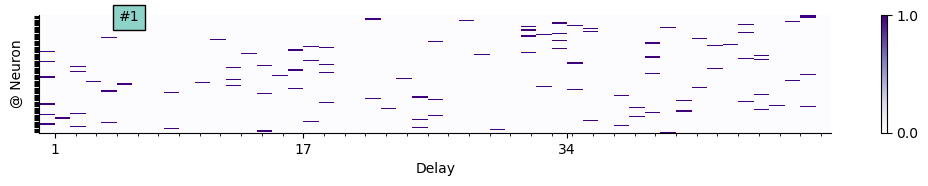

In [5]:
world_parameters = dataset_parameters();
sm = sm_generative_model(world_parameters, device = device)
plot_SM(sm.SMs);

../synthetic_data/synthetic_rp_trainset_30_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0.1_1_666.pt
../synthetic_data/synthetic_rp_testset_30_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0.1_1_666.pt


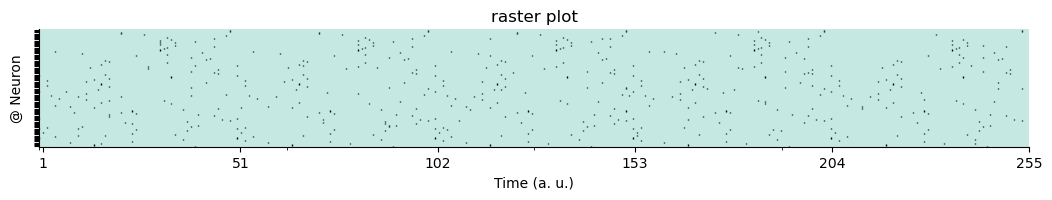

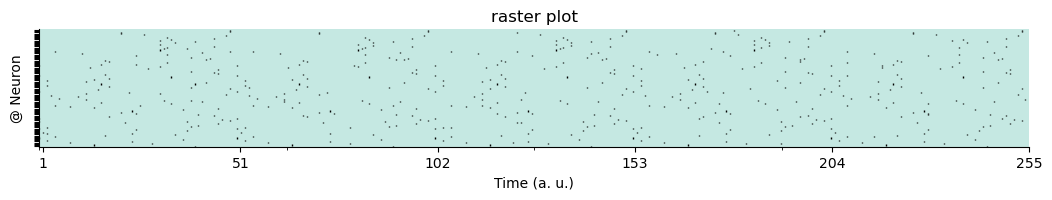

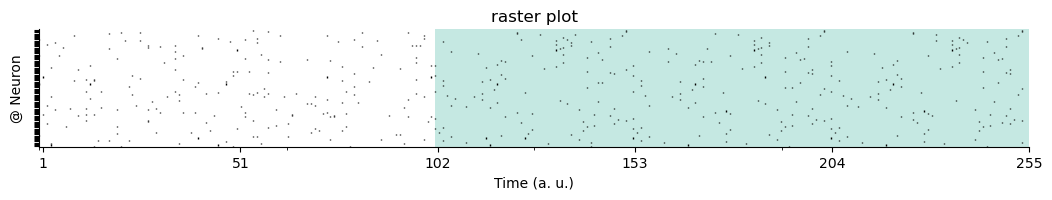

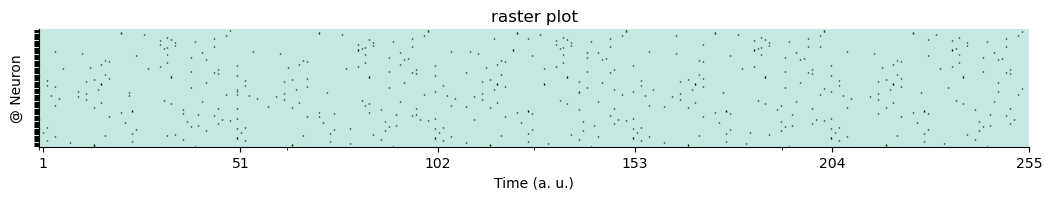

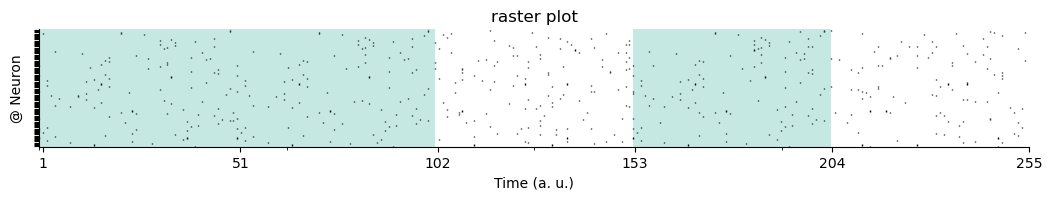

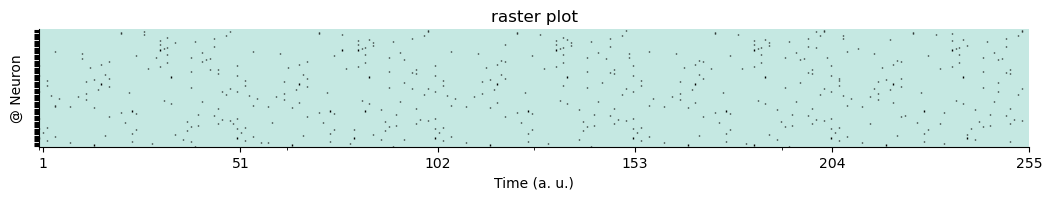

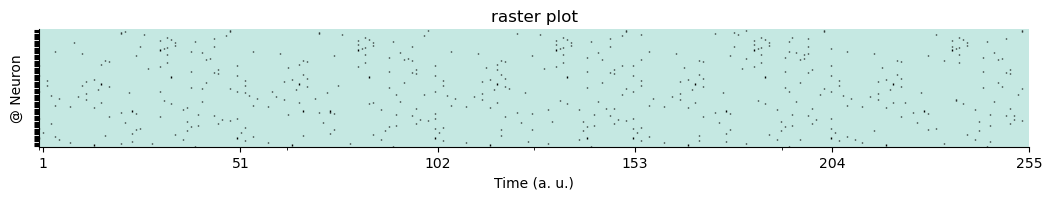

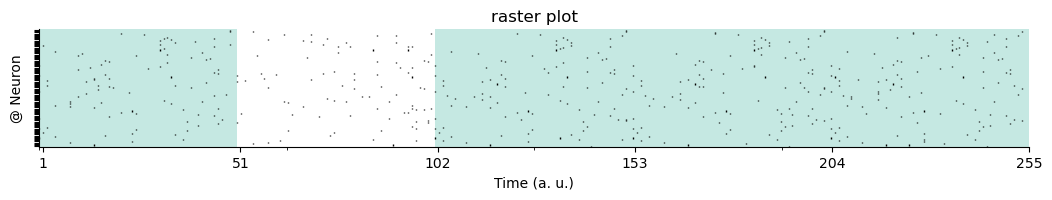

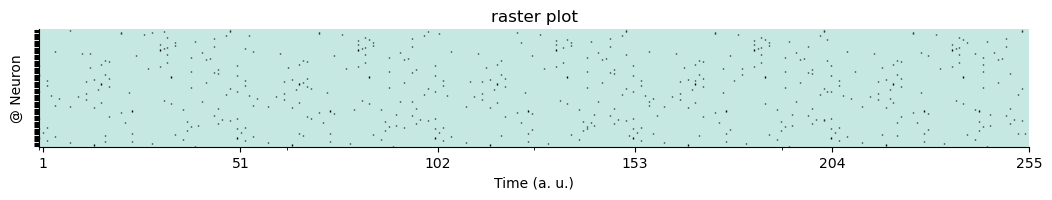

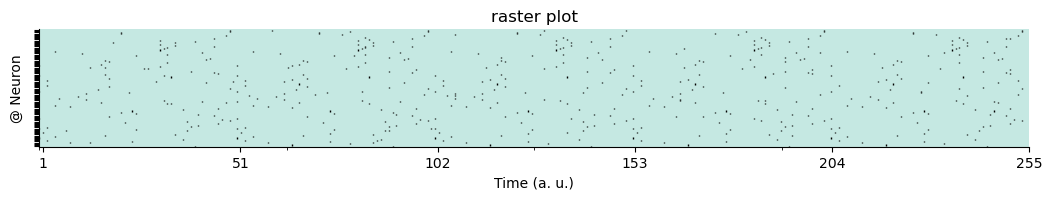

In [6]:
sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(world_parameters, device=device)
for i in range(min(10,trainset_input.shape[0])):
    fig_raster, ax_raster = plot_colored_raster(trainset_input, trainset_output.cpu().numpy(), world_parameters.N_delays, indice_trial=i);

In [7]:
def performance_as_a_function_of_noise(world_parameters, training_parameters, date, coefficients, N_iter = 5, seeds = None, device='cpu'):
    
    results = torch.zeros([3,N_iter,len(coefficients),6])
    if seeds is not None:
        assert seeds.size(0)==N_iter
    else:
        seeds = torch.randint(1000,[N_iter])
    
    params_mse = training_parameters()
    params_emd = training_parameters()
    params_emd.loss_type = 'emd'
    file_name = f'results/{date}_performance_as_a_function_of_noise_{world_parameters.get_parameters()}_{params_mse.get_parameters()}_{coefficients[0]}_{coefficients[-1]}'
    print(file_name)
    
    if os.path.isfile(file_name):
        results, coefficients = torch.load(file_name, map_location=device)
    else:
        pbar = tqdm(total=len(coefficients)*N_iter)
        for ind_f, coef in enumerate(coefficients):
            world_parameters.additive_noise = coef
            for i in range(N_iter):
                world_parameters.seed = seeds[i]
                sm, trainset_input, trainset_output, testset_input, testset_output = generate_dataset(world_parameters,verbose = False, device=device)
                results[0,i,ind_f,0], results[0,i,ind_f,1], results[0,i,ind_f,2], results[0,i,ind_f,3], results[0,i,ind_f,4], results[0,i,ind_f,5], _, _ = train_and_plot(world_parameters, sm, trainset_input, testset_input, testset_output, [params_mse], date, iteration = i, device=device)
                results[1,i,ind_f,0], results[1,i,ind_f,1], results[1,i,ind_f,2], results[1,i,ind_f,3], results[1,i,ind_f,4], results[1,i,ind_f,5], _, _ = train_and_plot(world_parameters, sm, trainset_input, testset_input, testset_output, [params_emd], date, iteration = i, device=device)
                results[2,i,ind_f,0], results[2,i,ind_f,1], results[2,i,ind_f,2], results[2,i,ind_f,3], results[2,i,ind_f,4], results[2,i,ind_f,5], _, _ = train_and_plot(world_parameters, sm, trainset_input, testset_input, testset_output, [params_emd, params_mse], date, iteration = i, device=device)
                
                pbar.update(1)

        pbar.close()
        torch.save([results, coefficients], file_name)
    return results, coefficients

In [8]:
class training_parameters:
    kernel_size = (sm.opt.N_SMs, sm.opt.N_pre, sm.opt.N_delays)
    loss_type = 'mse'
    N_learnsteps = 1000
    learning_rate = .001
    penalty_type = None
    smoothwind = 20
    lambda_ = .01
    batch_size = 5
    output = 'linear' 
    do_bias = True 
    zeros = 'ignore'
    wass_order = 1
    weight_init = None
    if not penalty_type: 
        lambda_ = 0
    elif penalty_type[:8] != 'smoothed':
        smoothwind = 0
    if lambda_ == 0:
        penalty_type = None
    def get_parameters(self):
        name = f'{self.loss_type}_{self.output}_{self.penalty_type}_{self.do_bias}_{self.kernel_size}_{self.N_learnsteps}_{self.learning_rate}_{self.lambda_}_{self.batch_size}_{self.smoothwind}'
        if self.loss_type == 'emd':
            name += f'_{self.zeros}_{self.wass_order}'
        return name

In [ ]:
N_iter = 20
coefficients = torch.arange(0,1,.1)
seeds = torch.tensor([10, 17, 73, 95,  6, 22,  4, 66,  7,  3, 21,  0, 53, 47, 89, 49, 76, 34, 14, 35])
results, coefficients = performance_as_a_function_of_noise(world_parameters, training_parameters, date, coefficients, N_iter = N_iter, seeds = seeds, device=device)

results/2024-01-15_performance_as_a_function_of_noise_100_51_1_255_60_100.0_20_16.0_False_0.1_0_0.1_1_666_mse_linear_None_True_(1, 100, 51)_1000_0.001_0_5_20_0.0_0.8999999761581421


  0%|                                                                                                                                                           | 0/200 [00:00<?, ?it/s]

In [ ]:
from wassa_plots import plot_results_std
import matplotlib.pyplot as plt

name_metrics = ['factors similarity', 'kernels similarity', 'mean timings\nsimilarity', 'MSE', 'EMD', 'EMD means']
name_methods = ['MSE', 'EMD', 'combined']
colors = ['darkolivegreen','blue','orangered']
xlabel = 'additive noise (in %)'

results = results.cpu()
for i in range(len(name_metrics)):
    fig, ax = plt.subplots()
    for m in range(len(name_methods)):
        ax = plot_results_std(ax,results[m,:,:,i],coefficients.cpu(),xlabel,name_metrics[i],name_methods[m],colors[m])